In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as date
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import shapefile as shp

import os
pd.set_option('display.max_rows', 20)
!date

%load_ext autoreload
%autoreload 2

Tue Jun 30 10:05:48 PDT 2020


In [4]:
from viz_mobility import *
from micromap_fn import *

# UW mobility micromaps

## pull all dates from feb 1st onwards

In [8]:
%%time

dir_2020 = '/ihme/limited_use/LIMITED_USE/PROJECT_FOLDERS/COVID19/SAFEGRAPH/social_distancing/2020'
raw = pd.DataFrame()

for month in ['02', '03', '04', '05', '06']:    
    days = os.listdir(dir_2020 + '/' + month)
    for day in days:
        df = compile_data_uw(month, day)
        raw = raw.append(df)

CPU times: user 13min 2s, sys: 1min 44s, total: 14min 46s
Wall time: 15min 13s


In [249]:
%%time
baseline = calc_baseline(month = 2, days = np.arange(8,15))

CPU times: user 35.7 s, sys: 3.34 s, total: 39 s
Wall time: 39.1 s


In [136]:
# # add in missing geoid using the surrounding ones
# missing_val = baseline[baseline.origin_census_block_group.isin(['530330052001',
#                                                                 '530330052004',
#                                                                 '530330045001',
#                                                                 '530330053012',
#                                                                 '530330053013',
#                                                                 '530330052002'])].baseline_not_at_home.mean()

# baseline.loc[baseline.shape[0]] = ['530330052005',missing_val]

In [250]:
%%time
data_long = add_sip_index(raw, baseline)

CPU times: user 187 ms, sys: 11.1 ms, total: 198 ms
Wall time: 194 ms


/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Warning: baseline missing for the following geoids: ['530330052005']
  
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Warning: sip_index==nan for the following geoids: ['530330052005']


## merge on population counts

In [252]:
pdensity_path = '/home/j/Project/simulation_science/covid/data/census_data/2020_05_14_king_county_population_distribution_2010.csv'
pop_density = pd.read_csv(pdensity_path, usecols = ['total_pop','area','geoid'], dtype='str')

pop_density.total_pop = pop_density.total_pop.astype(int)
pop_density.area = pop_density.area.astype(float)
pop_density['blkgrp_geoid'] = pop_density.geoid.str[:12]

pop_density = pop_density.groupby('blkgrp_geoid').sum()
pop_density['density'] = pop_density['total_pop'] / pop_density['area']
pop_density = pop_density.reset_index()

In [253]:
data_long = data_long.merge(pop_density, left_on='origin_census_block_group', right_on = 'blkgrp_geoid', how='left')

In [254]:
# find sip timeseries
data = data_long.pivot(index='date', columns='origin_census_block_group', values='sg_sip_index')
data = add_rolling_avg(data, windows = [7, 14, 21])

In [255]:
# find device_count timeseries
dcount = data_long.pivot(index='date', columns='origin_census_block_group', values='device_count')
dcount = add_rolling_avg(dcount, windows = [7, 14, 21])

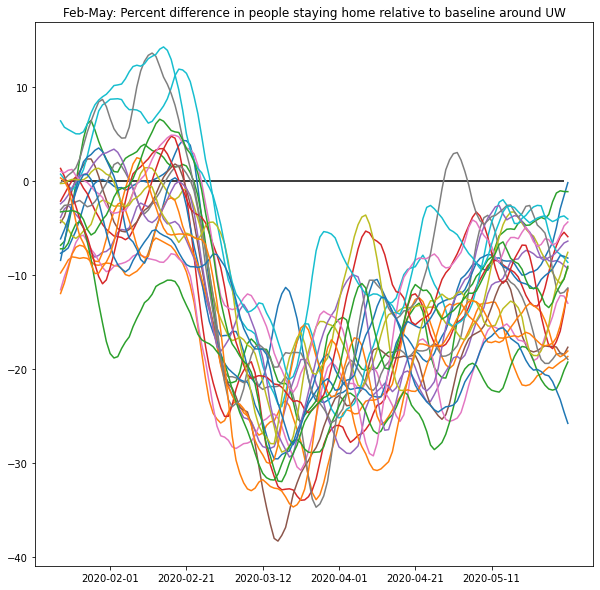

In [192]:
## plot 7 day rolling avg    

plt.figure(figsize=(10,10))

cols = [i for i in data.columns if i.endswith('7day_avg')]

for y in cols:
    plt.plot(data[['num_date']], data[[y]])

plt.hlines(0,data.num_date.min()+7,data.num_date.max()-7)

plt.title('Feb-May: Percent difference in people staying home relative to baseline around UW')
plt.xticks(ticks = np.arange(737476,data.num_date.max()-7,20),
           labels=data[data.num_date.isin(np.arange(737456.0,data.num_date.max()-7,20))].index.tolist())
plt.show()

# plot micromaps

In [257]:
import sys
sys.path.append('./')
from micromap_fn_2020_06_30 import *

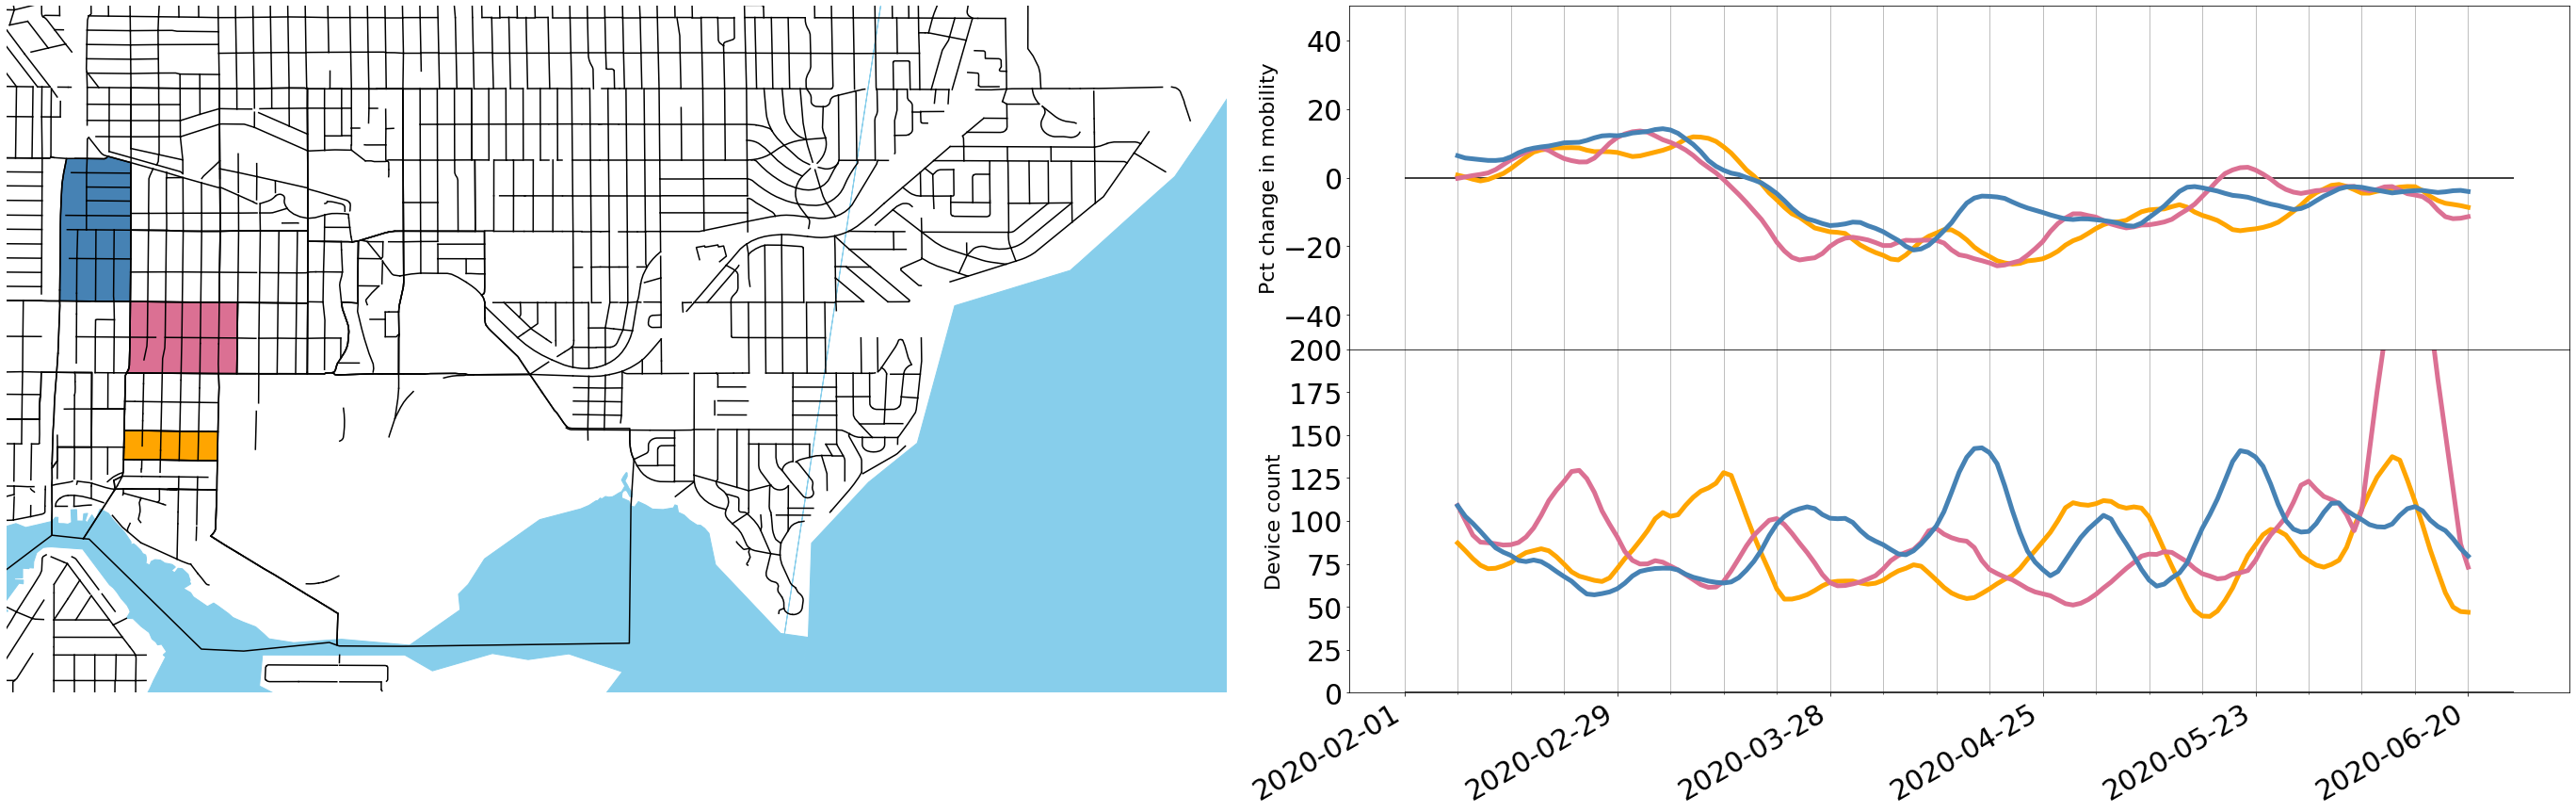

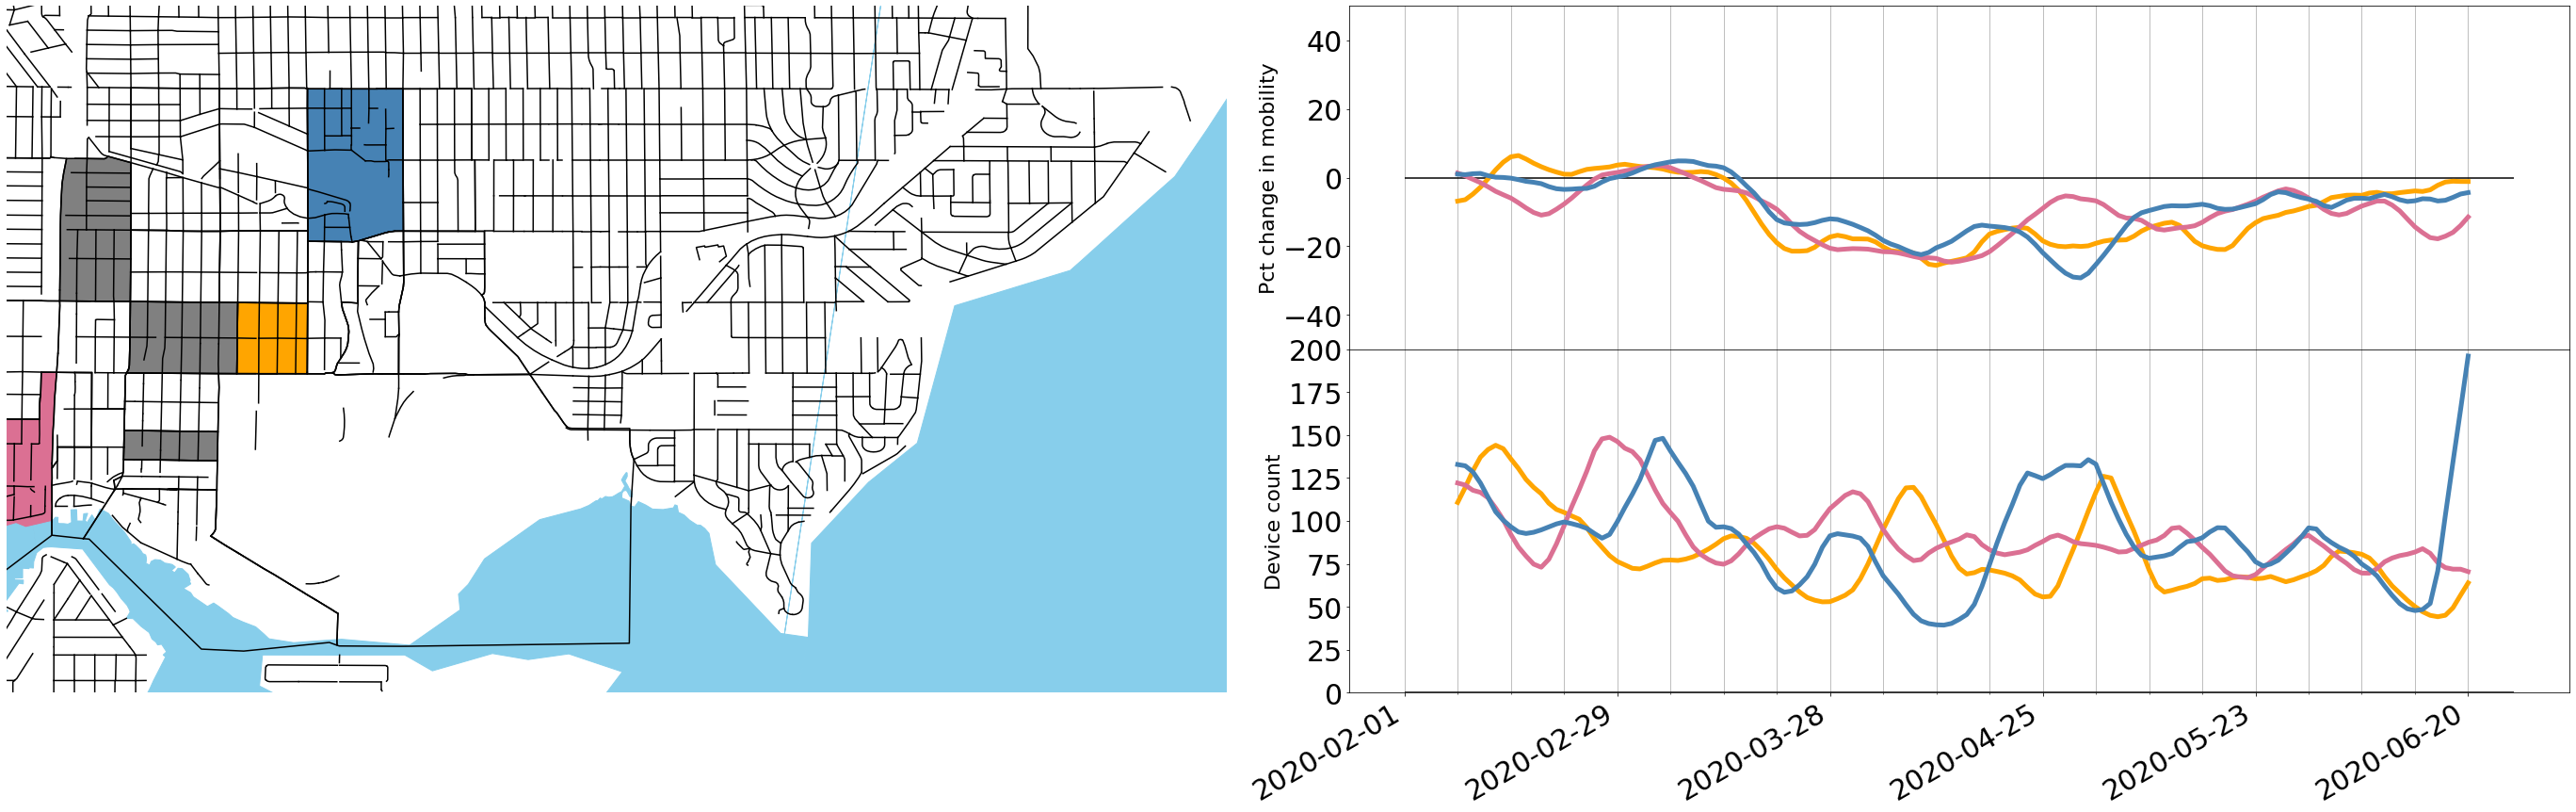

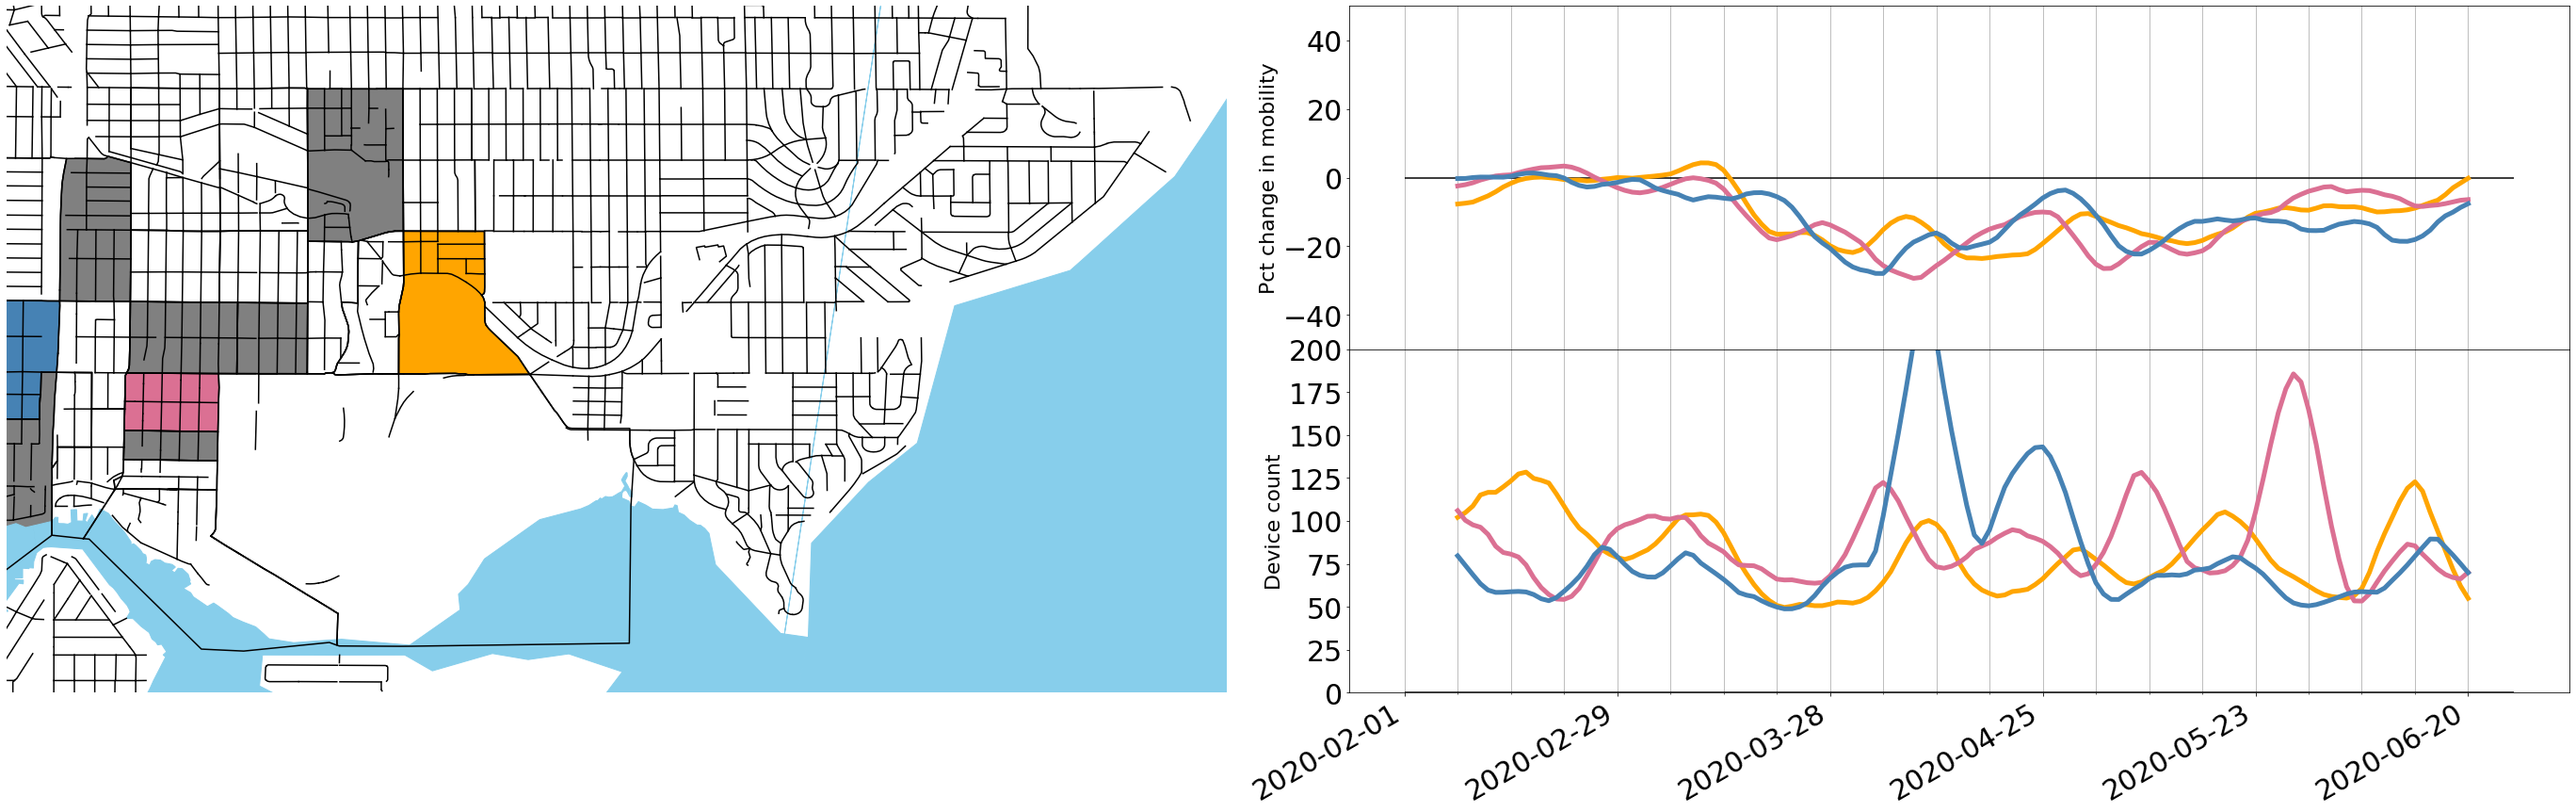

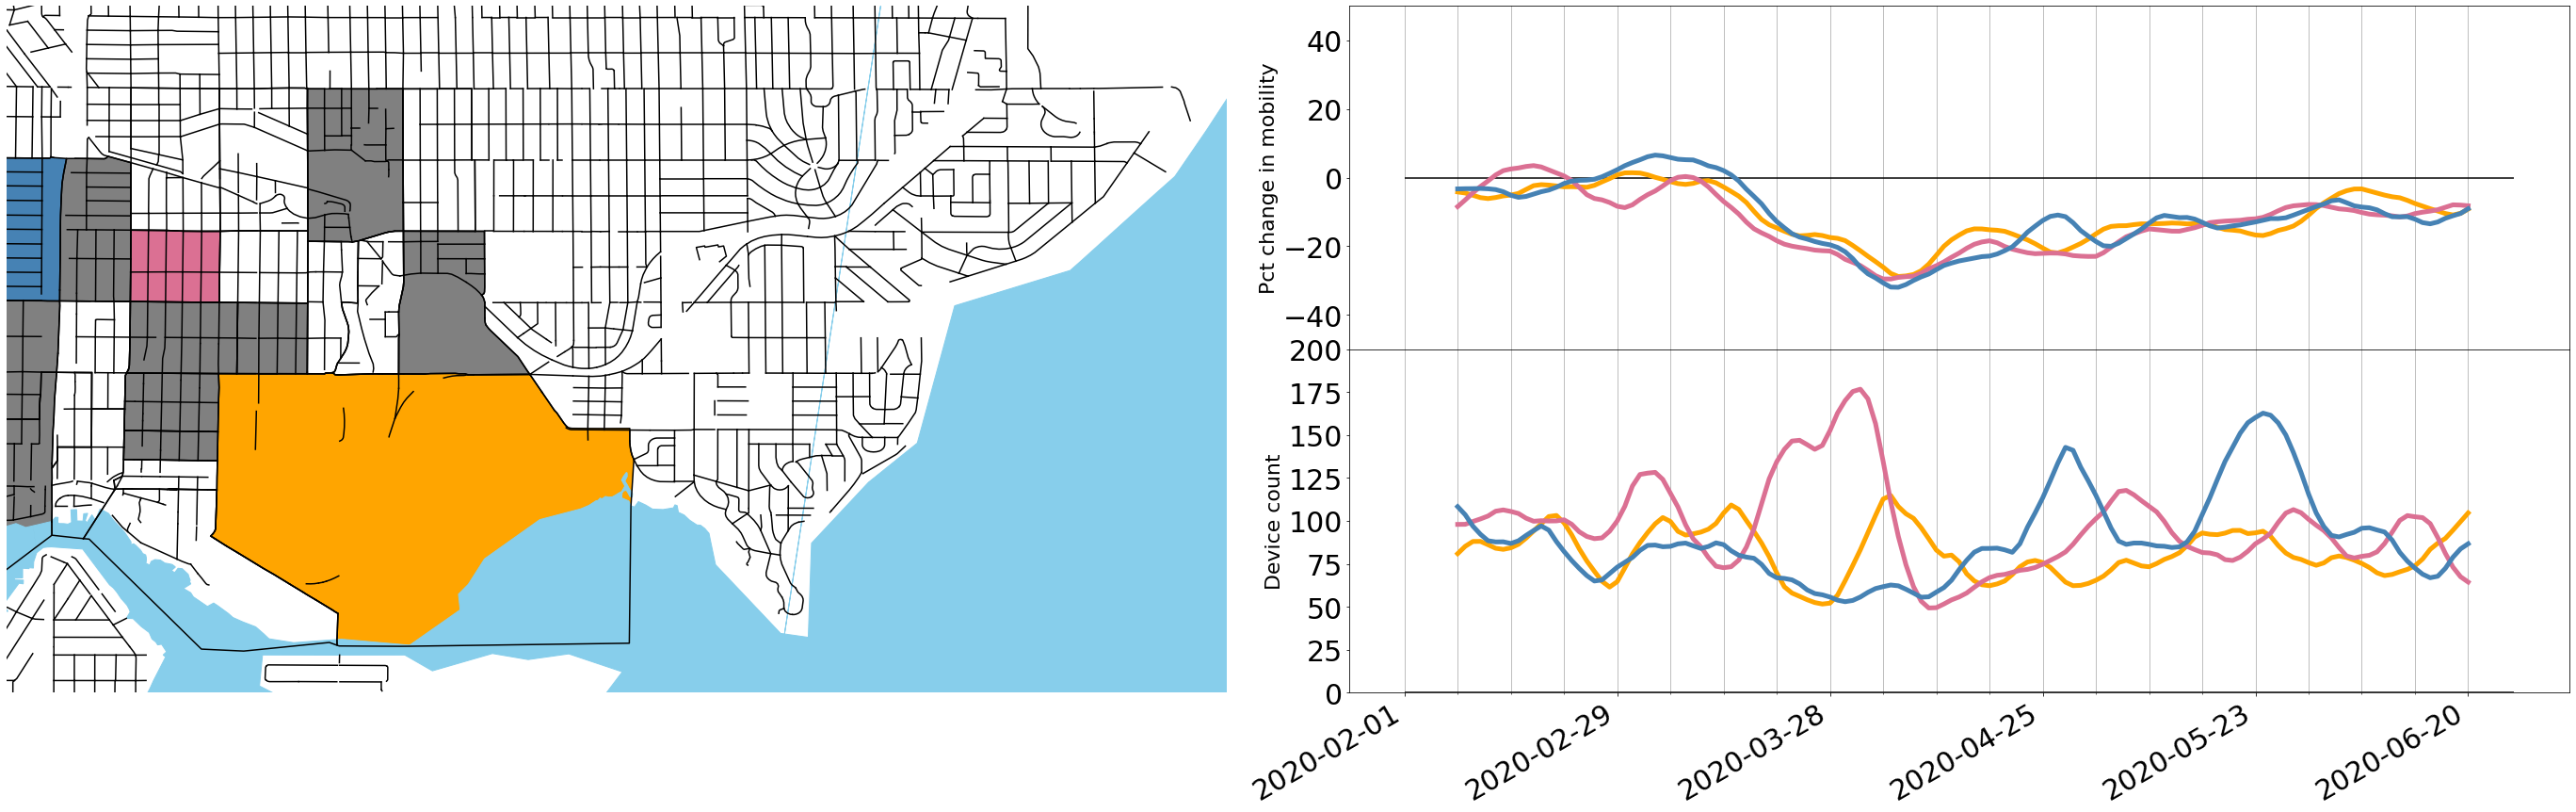

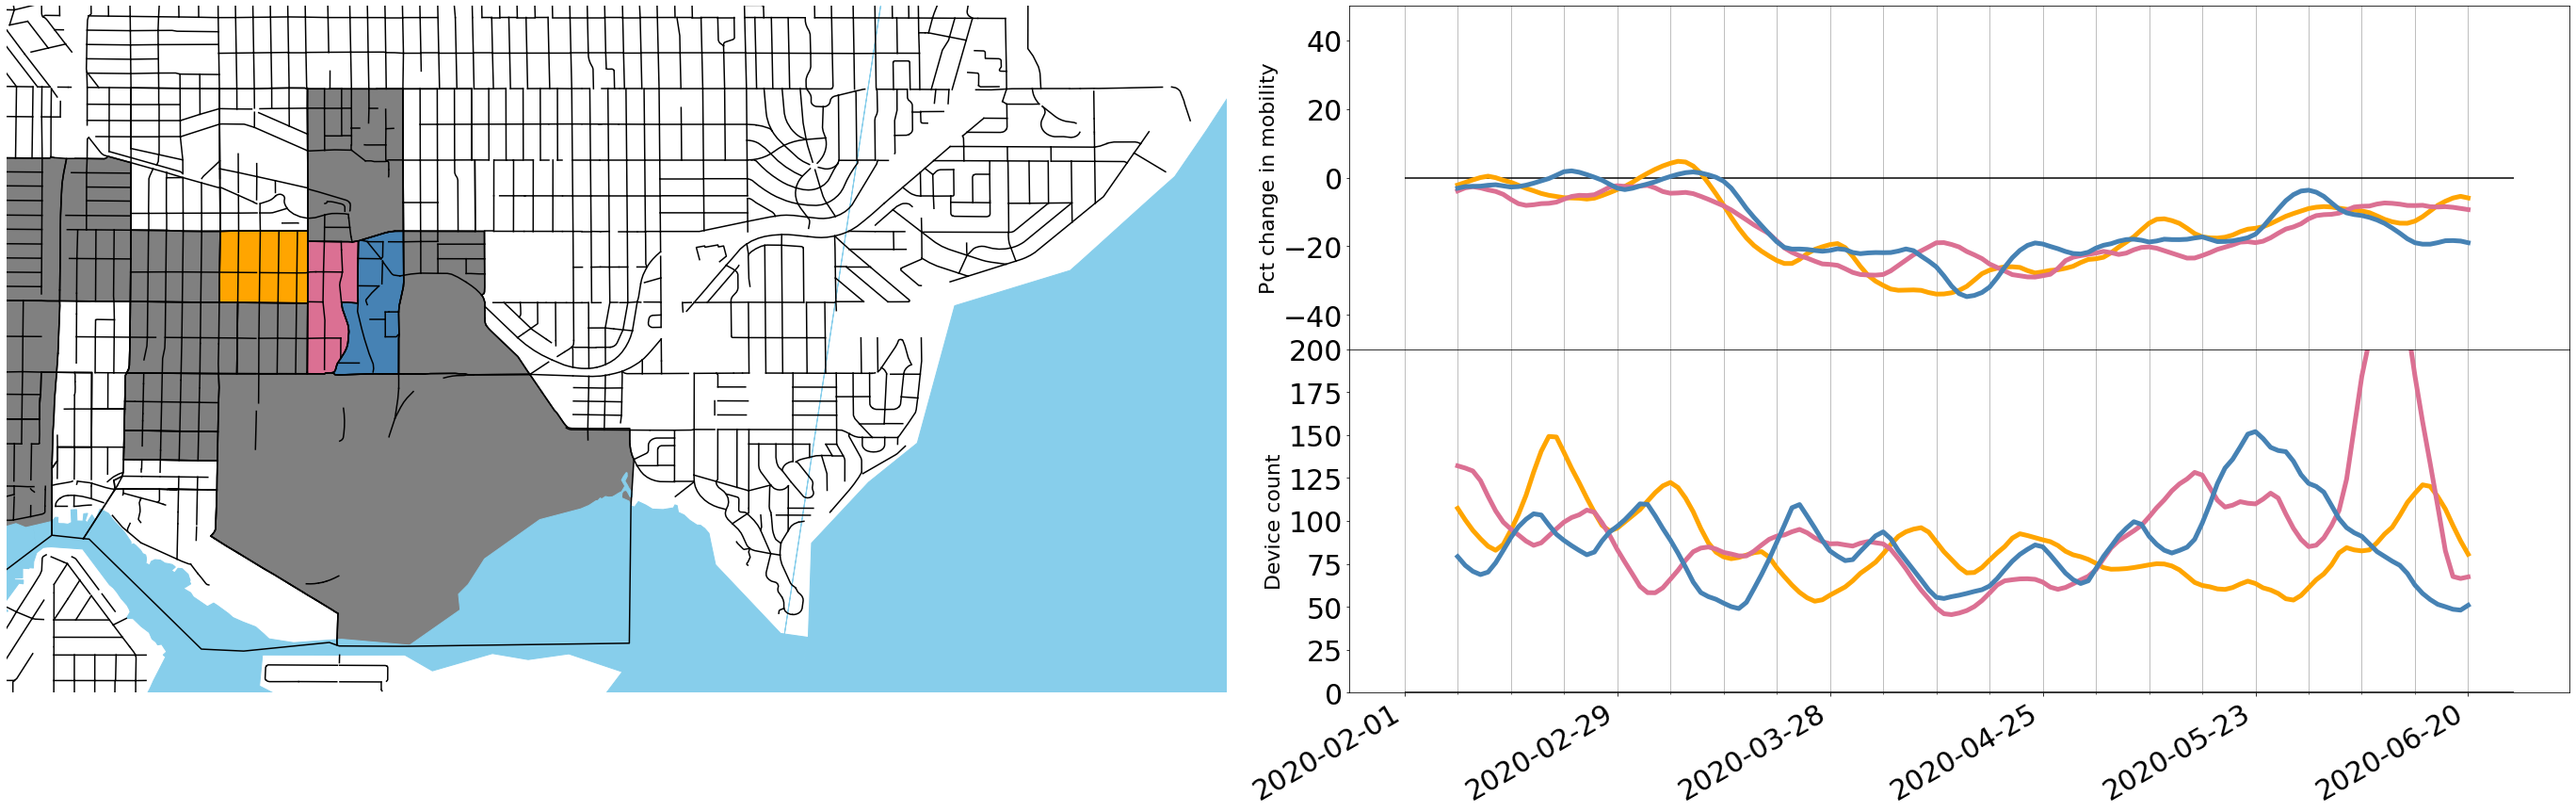

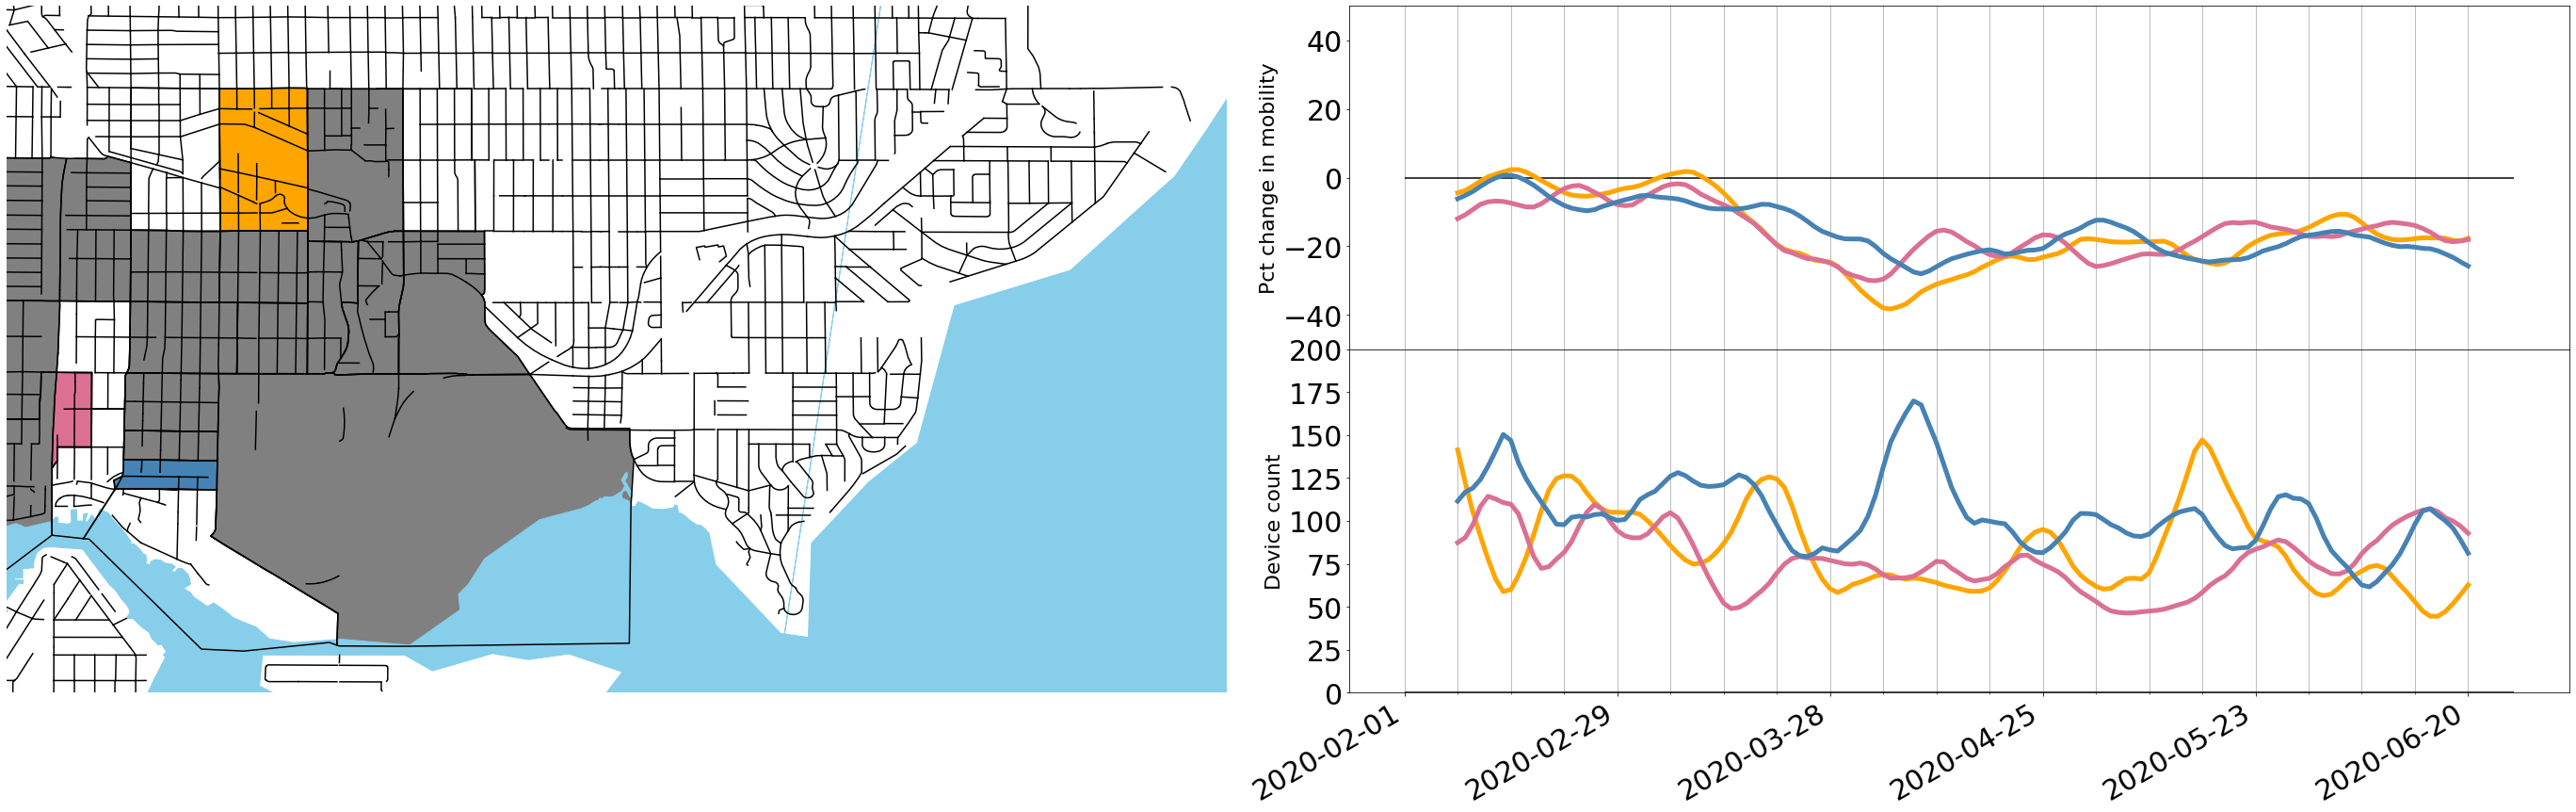

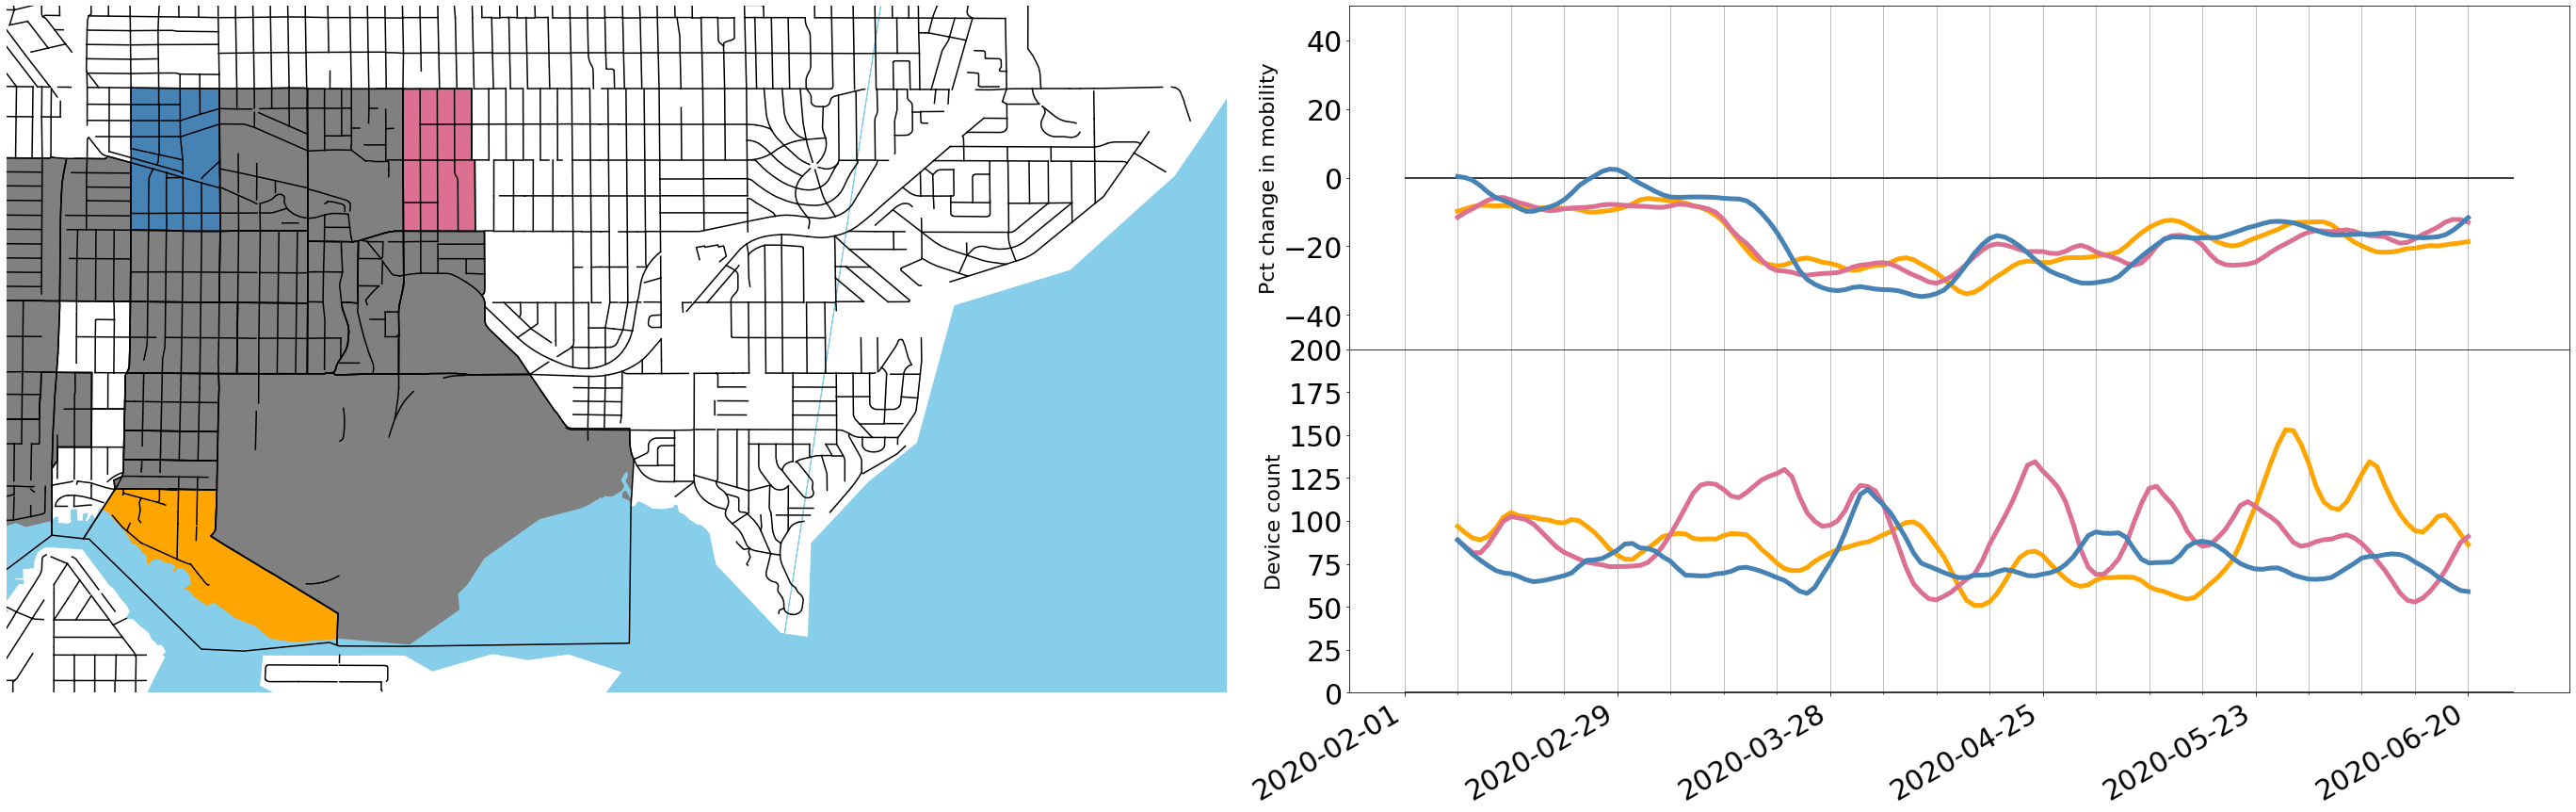

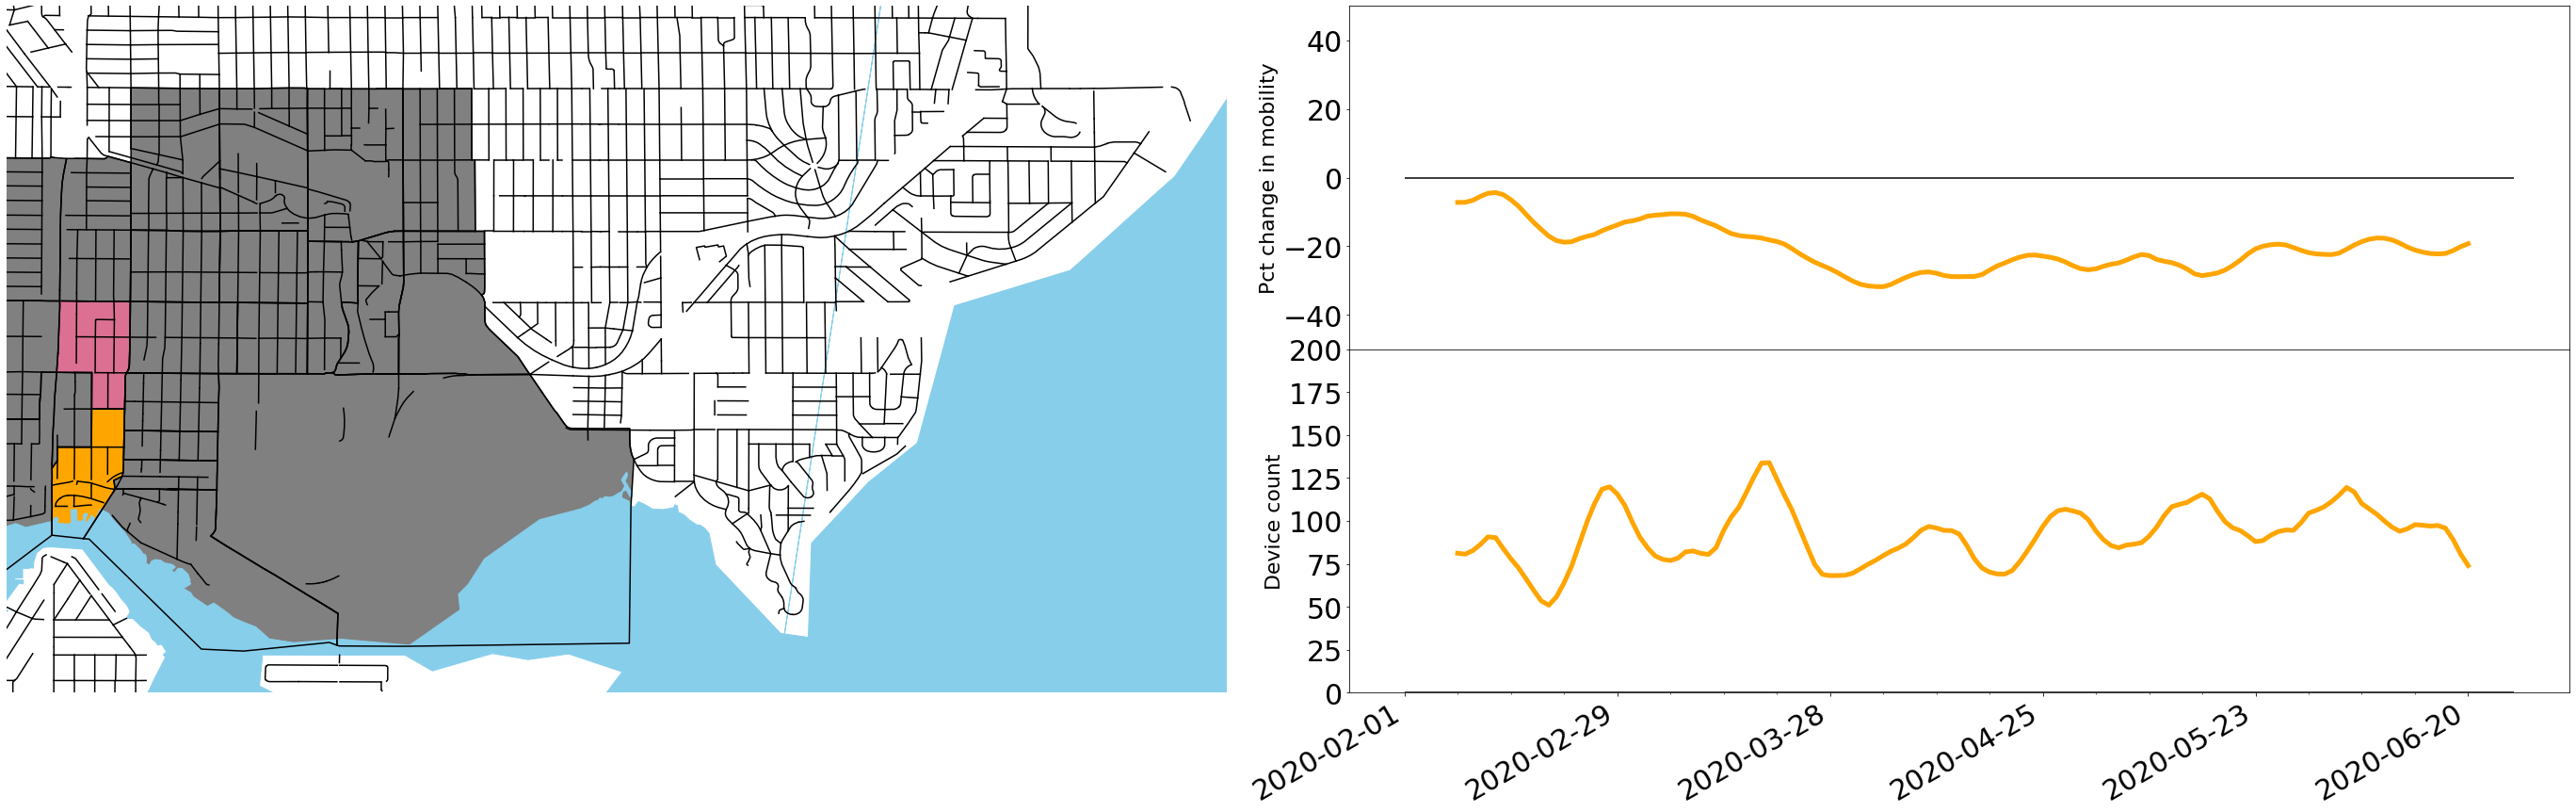

In [259]:
order_df = find_order(data, ending = '21day_avg', fn = np.mean)
left = bottom = 0 
height = 1.5
width_map = 3
width_time = 3

k = 4.5


with PdfPages(f'/homes/beatrixh/repos/scratch/micromaps_test.pdf') as pdf:
    for i in np.arange(1,9):
        fig = plt.figure(figsize=(width_map+width_time,height*k,))
        plot_mult_locations(sf, df, data, dcount, order_df[order_df.plot_group==float(i)].geoid.tolist(), all_geoids,
                            left, bottom, w_map = width_map, w_time = width_time, h = height)
        if i > 1:
            fill_blockgroups(sf, df, order_df[order_df.plot_group<float(i)].geoid.tolist(), ['grey'] * (i-1)*3)
            
        fill_water(df_water, sf_water)
        
        bottom = bottom - height
        pdf.savefig(fig, bbox_inches='tight')